# Graph 

In [1]:
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } </style>"))
import matplotlib.pyplot as plt

In [2]:
from pkg.realsense import *
from pkg.kinect import *
from pkg.marker_config import *
from pkg.stereo import *

pipeline=init_rs()
init_kn()
aruco_map, dictionary = get_aruco_config()

Start streaming
Open K4A Device failed!


  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/home/junsu/.local/lib/python2.7/site-packages/tornado/ioloop.py", line 832, in start
    self._run_callback(self._callbacks.popleft())
  File "/home/junsu/.local/lib/python2.7/site-packages/tornado/ioloop.py", line 605, in _run_callback
    ret = callback()
  File "/home/junsu/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python

SystemExit: 1

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
T_c21, kn_config, rs_config = calibrate_stereo(aruco_map, dictionary)
cameraMatrix, distCoeffs  = kn_config

In [4]:
from pkg.calibrator import *
TEST_CALIB = True

if TEST_CALIB:
    try: T_bbbr_load_panda, T_rooo_load_panda, Teo_ref_load_panda = load_offset("panda")
    except: T_bbbr_load_panda, T_rooo_load_panda, Teo_ref_load_panda = [np.identity(4)]*3
    try: T_bbbr_load_indy, T_rooo_load_indy, Teo_ref_load_indy = load_offset("indy_sd")
    except: T_bbbr_load_indy, T_rooo_load_indy, Teo_ref_load_indy = [np.identity(4)]*3
else:
    T_bbbr_load_panda, T_rooo_load_panda, Teo_ref_load_panda = [np.identity(4)]*3
    T_bbbr_load_indy, T_rooo_load_indy, Teo_ref_load_indy = [np.identity(4)]*3
T_reeo_load_panda = np.matmul(np.matmul(Teo_ref_load_panda, T_rooo_load_panda),SE3_inv(Teo_ref_load_panda))
T_reeo_load_indy = np.matmul(np.matmul(Teo_ref_load_indy, T_rooo_load_indy),SE3_inv(Teo_ref_load_indy))

In [8]:
while True:
    try:
        objectPose_dict, corner_dict, color_image, rs_image, rs_corner_dict, objectPoints_dict, point3D_dict, err_dict = \
            get_object_pose_dict_stereo(T_c21, kn_config, rs_config, aruco_map, dictionary)
#         color_image, depth_image = get_kinect_image_depth()
#         objectPose_dict, corner_dict = get_object_pose_dict_stereo(aruco_map, dictionary, cameraMatrix, distCoeffs)
#         refine_by_depth(depth_image, objectPose_dict, corner_dict, aruco_map, cameraMatrix, distCoeffs)
        Tbi = get_T_rel('floor', 'indy0', objectPose_dict)
        Tbi =  np.matmul(Tbi, T_bbbr_load_indy)
        xyz_indy0, rpy_indy0 = T2xyzrpy(Tbi)
        Tbp = get_T_rel('floor', 'panda1', objectPose_dict)
        Tbp = np.matmul(Tbp, T_bbbr_load_panda)
        xyz_panda1, rpy_panda1 = T2xyzrpy(Tbp)
        T_bc = SE3_inv(objectPose_dict['floor'])
        T_bo_0 = get_T_rel('floor', 'box1', objectPose_dict)
        xyz_cam, rvec_cam = T2xyzrvec(T_bc)
        xyz_box1, rvec_box1 = T2xyzrvec(T_bo_0)
        xyz_goal, rvec_goal = T2xyzrvec(get_T_rel('floor', 'goal', objectPose_dict))
        xyz_wall, rvec_wall = T2xyzrvec(get_T_rel('floor', 'wall', objectPose_dict))
        break
    except KeyError as e:
        print(e)
        break
    except Exception as e:
        print(e)
        pass

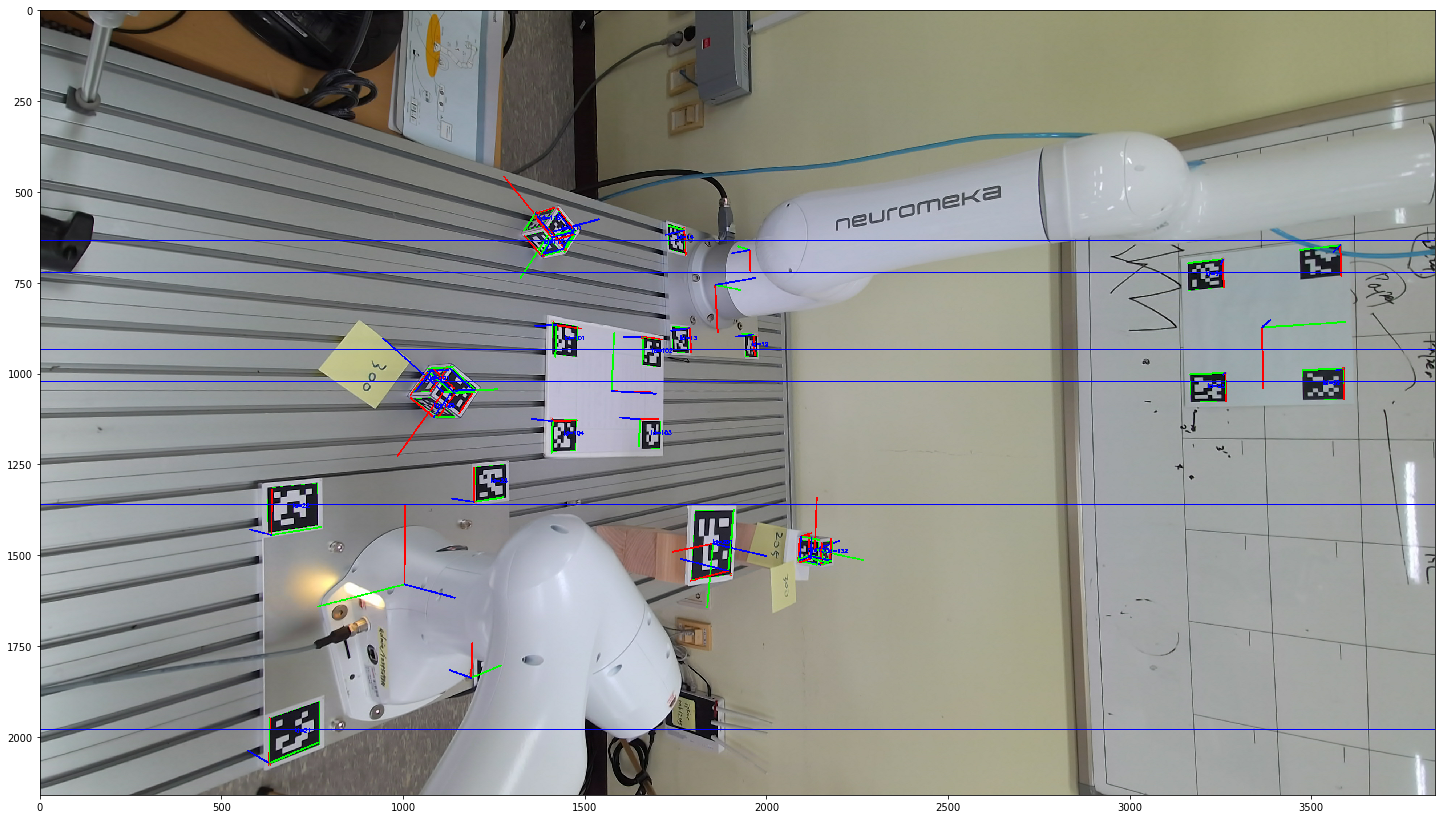

In [9]:
color_image_out = draw_objects(color_image, aruco_map, objectPose_dict, corner_dict, cameraMatrix, distCoeffs, axis_len=0.1)
plt.figure(figsize=(25,15))
plt.imshow(color_image_out[:,:,[2,1,0]])

In [18]:
Tbb12 = get_T_rel('box1', 'box2', objectPose_dict)
print(Tbb12)

[[ 0.02404271 -0.03321965  0.99915886 -0.00770208]
 [ 0.99951494  0.02058771 -0.02336679  0.30217984]
 [-0.01979416  0.99923605  0.03369848 -0.02051347]
 [ 0.          0.          0.          1.        ]]


In [14]:
Tbb1 = get_T_rel('floor', 'box1', objectPose_dict)
print(Tbb1)

[[-0.79715264 -0.6015064   0.05232264 -0.14660054]
 [ 0.60294306 -0.78850067  0.12135213  0.23746519]
 [-0.03173766  0.12828372  0.9912296   0.00360841]
 [ 0.          0.          0.          1.        ]]


In [15]:
Tbb2 = get_T_rel('floor', 'box2', objectPose_dict)
print(Tbb2)

[[-0.62141603  0.06638013 -0.7806636  -0.3232972 ]
 [-0.77602386  0.08499643  0.62495    -0.00793706]
 [ 0.1078379   0.9941677  -0.00130562  0.02228409]
 [ 0.          0.          0.          1.        ]]


In [16]:
Tbb3 = get_T_rel('floor', 'box3', objectPose_dict)
print(Tbb3)

[[-0.01482245 -0.04823206  0.9987262   0.30441713]
 [ 0.99988616  0.00211584  0.01494185 -0.2844309 ]
 [-0.00283382  0.99883395  0.04819521  0.25173426]
 [ 0.          0.          0.          1.        ]]


In [17]:
Tbb3 = get_T_rel('floor', 'goal', objectPose_dict)
print(Tbb3)

[[-9.9853295e-01 -5.4143790e-02 -5.8925163e-04  1.8965304e-02]
 [ 5.4146878e-02 -9.9844897e-01 -1.2950721e-02 -2.3134710e-01]
 [ 1.1280499e-04 -1.2963630e-02  9.9991602e-01  2.1671253e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


In [11]:
rs_corner_dict

{12: array([[803., 865.],
        [801., 824.],
        [824., 820.],
        [826., 862.]], dtype=float32), 13: array([[951., 852.],
        [949., 803.],
        [981., 799.],
        [984., 849.]], dtype=float32), 14: array([[ 963., 1063.],
        [ 961., 1009.],
        [ 994., 1010.],
        [ 997., 1065.]], dtype=float32), 21: array([[1597.,   61.],
        [1607.,  119.],
        [1542.,  146.],
        [1533.,   88.]], dtype=float32), 22: array([[1652.,  382.],
        [1664.,  450.],
        [1593.,  467.],
        [1582.,  402.]], dtype=float32), 23: array([[1334.,  470.],
        [1340.,  527.],
        [1289.,  539.],
        [1283.,  483.]], dtype=float32), 101: array([[1222.,  813.],
        [1175.,  814.],
        [1171.,  755.],
        [1218.,  752.]], dtype=float32), 102: array([[1044.,  816.],
        [1007.,  818.],
        [1005.,  766.],
        [1042.,  763.]], dtype=float32), 103: array([[1039.,  655.],
        [1003.,  660.],
        [1002.,  611.],
        [

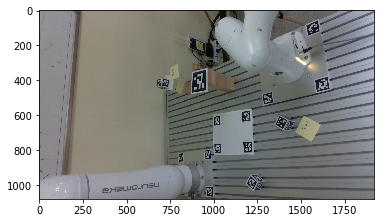

In [10]:

plt.imshow(rs_image[:,:,[2,1,0]])

In [7]:
# disconnect_kn()
# disconnect_rs()

In [8]:
urdf_content = None
from pkg.robots_custom import *
xcustom = XacroCustomizer()
xcustom.clear()
# xcustom.add_robot(RobotType.indy7_robot, xyz=[0,-0.5,0], rpy=[0,0,0])
# xcustom.add_robot(RobotType.panda_robot, xyz=[0,0.5,0], rpy=[0,0,0])
xcustom.add_robot(RobotType.indy7_robot, xyz=xyz_indy0, rpy=rpy_indy0)
xcustom.add_robot(RobotType.panda_robot, xyz=xyz_panda1, rpy=rpy_panda1)
xcustom.write_xacro()
vel_scale = 1.0/2.0
effort_scale = 1.0/2.0
JOINT_NAMES, LINK_NAMES, ZERO_JOINT_POSE, urdf_content = \
        xcustom.convert_xacro_to_urdf(
        joint_fix_dict={'finger':'upper'},
        joint_offset_dict={'panda1_hand_joint': T_reeo_load_panda, 'indy0_tcp': T_reeo_load_indy},
        vel_limit_dict={k: v*vel_scale for k,v in {
            'panda1_joint1': np.deg2rad(150),  'panda1_joint2': np.deg2rad(150), 
            'panda1_joint3': np.deg2rad(150), 'panda1_joint4': np.deg2rad(150), 
            'panda1_joint5': np.deg2rad(180), 'panda1_joint6': np.deg2rad(180), 'panda1_joint7': np.deg2rad(180), 
            'indy0_joint0': np.deg2rad(150), 'indy0_joint1': np.deg2rad(150), 'indy0_joint2': np.deg2rad(150), 
            'indy0_joint3': np.deg2rad(180), 'indy0_joint4': np.deg2rad(180), 'indy0_joint5': np.deg2rad(180), 
        }.items()},
        effort_limit_dict={k: v*effort_scale for k,v in {
            'panda1_joint1': np.deg2rad(360),  'panda1_joint2': np.deg2rad(360), 
            'panda1_joint3': np.deg2rad(360), 'panda1_joint4': np.deg2rad(360), 
            'panda1_joint5': np.deg2rad(360), 'panda1_joint6': np.deg2rad(360), 'panda1_joint7': np.deg2rad(360), 
            'indy0_joint0': np.deg2rad(360), 'indy0_joint1': np.deg2rad(360), 'indy0_joint2': np.deg2rad(360), 
            'indy0_joint3': np.deg2rad(360), 'indy0_joint4': np.deg2rad(360), 'indy0_joint5': np.deg2rad(360), 
        }.items()}
    )
ZERO_JOINT_POSE=np.array([0,0,-np.pi/2,0,-np.pi/2,0,
                          0,-np.pi/8,0,-np.pi/2,0,np.pi/2,0])
refine_meshes()
xcustom.start_rviz()
    
from pkg.constraint_graph import *
from pkg.constants import *
import matplotlib.pyplot as plt
from pkg.plot_utils import *
from pkg.utils import *
# from threading import Thread, Lock
from multiprocessing import Process, Lock, Manager
PROC_MODE = True
rospy.init_node('task_planner', anonymous=True)

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


In [9]:
gtimer = GlobalTimer.instance()
gtimer.reset()
graph = ConstraintGraph(urdf_path=URDF_PATH, joint_names=JOINT_NAMES, link_names=LINK_NAMES, urdf_content=urdf_content,
                       connect_panda = True, connect_indy = True)
col_items_dict = graph.set_fixed_geometry_items(
    get_geometry_items_dict(graph.urdf_content, color=(0,1,0,0.5), display=True, collision=True, 
                             exclude_link=["panda1_link7"]))

Connect: Server IP (192.168.0.63)


# Custom Robots

In [10]:
gtimer.tic("set_scene")
collision=True
graph.add_geometry_items("base_link", 
                         [
                           GeoMesh(uri="package://my_mesh/meshes/stl/end_tool_asm_ctd.stl", BLH=(0.01,0.01,0.01), orientation_mat=Rot_axis(3,np.pi*2/16), scale=(1e-3,1e-3,1e-3), name="gripper1", link_name="indy0_tcp", 
                                   urdf_content=graph.urdf_content, color=(0.1,0.1,0.1,1), collision=False),
                           GeoBox(np.dot(Rot_axis(3,np.pi*2/16), (-0.055, 0,0.012)), (0.05,0.05,0.07), orientation=(0,0,np.pi*2/16), 
                                  name="gripper1_col", link_name="indy0_tcp", urdf_content=graph.urdf_content, color=(0,1,0,0.5), collision=collision),
                           GeoBox((0,0,-0.005), (3,3,0.01), name="floor", link_name="base_link", urdf_content=graph.urdf_content, color=(0.6,0.6,0.6,1), collision=collision),
                           GeoBox(xyz_wall, (3,3,0.05),orientation=rvec_wall, name="wall", link_name="base_link", urdf_content=graph.urdf_content, color=(0.6,0.6,0.6,1), collision=collision),
                           GeoBox(np.subtract(xyz_cam, [0,0,xyz_cam[2]/2]), 
                                  (0.1,0.1,xyz_cam[2]), 
                                  name="cam_pole", link_name="base_link", urdf_content=graph.urdf_content, color=(0.6,0.6,0.6,1), collision=collision),
#                            GeoBox((0.4,0.4,0.15), (0.15,0.15,0.3), name="stepper", link_name="base_link", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1), collision=collision),
                           GeoBox(xyz_goal, (0.1,0.1,1e-3),orientation=rvec_goal, name="goal_disp", link_name="base_link", urdf_content=graph.urdf_content, color=(0.8,0.0,0.0,1), collision=False)],
                         fixed=True)

graph.add_geometry_items("base_link", 
                         [GeoBox(xyz_box1, (0.05,0.05,0.05),orientation=rvec_box1, name="box1", link_name="base_link", urdf_content=graph.urdf_content, color=(0.3,0.3,0.8,1), collision=collision)],
                         fixed=False)

graph.register_binder(name='grip1', _type=VacuumTool, point=[0,-2.5e-2,11e-2], link_name="panda1_hand", direction=[0,1,0])
graph.register_binder(name='vac2', _type=VacuumTool, point=np.dot(Rot_axis(3,np.pi*2/16), (-0.055, 0,0.048)), link_name="indy0_tcp", direction=[0,0,1])
graph.register_binder(name='floor', _type=PlacePlane, direction=[0,0,1])
graph.register_binder(name='goal', _type=PlaceFrame, point=xyz_goal, orientation=rvec_goal, link_name="base_link")

box1_put_point = get_put_dir(Robj=Rotation.from_rotvec(rvec_box1).as_dcm(), dir_vec_dict=dir_vec_dict)+"_p"
graph.register_object('box1', _type=BoxAction, binding=(box1_put_point,"floor"), hexahedral=True)

graph.build_graph()
gtimer.toc("set_scene")
print("put_point: {}".format(box1_put_point))

put_point: front_p


# Set RVIZ

In [11]:
gtimer.tic("set_sim")
graph.set_planner(nWSR=300, regularization_factor= 1e-6)
gtimer.toc("set_sim")
# graph.show_pose(ZERO_JOINT_POSE, execute=True)

Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


In [12]:
if graph.connect_indy and graph.connect_panda:
    graph.show_pose(graph.get_real_robot_pose())
else:
    graph.show_pose(ZERO_JOINT_POSE)

# Calibration - indy

## Sample configurations

In [13]:
graph.set_camera_config(aruco_map, dictionary, kn_config, rs_config, T_c21)

In [14]:
if TEST_CALIB:
    Teo_ref = Teo_ref_load_indy
else:
    axis_vals = np.multiply(np.pi/2, (-1,1,1))
    Teo_ref = np.matmul(SE3(Rot_axis(3,np.pi*2/16), [0,0,0]), SE3(Rot_zyx(*axis_vals), [-0.055,0,0.071]))

In [15]:
sample_list = []
image_list = []

{'box1': 9.606845908908739e-05}


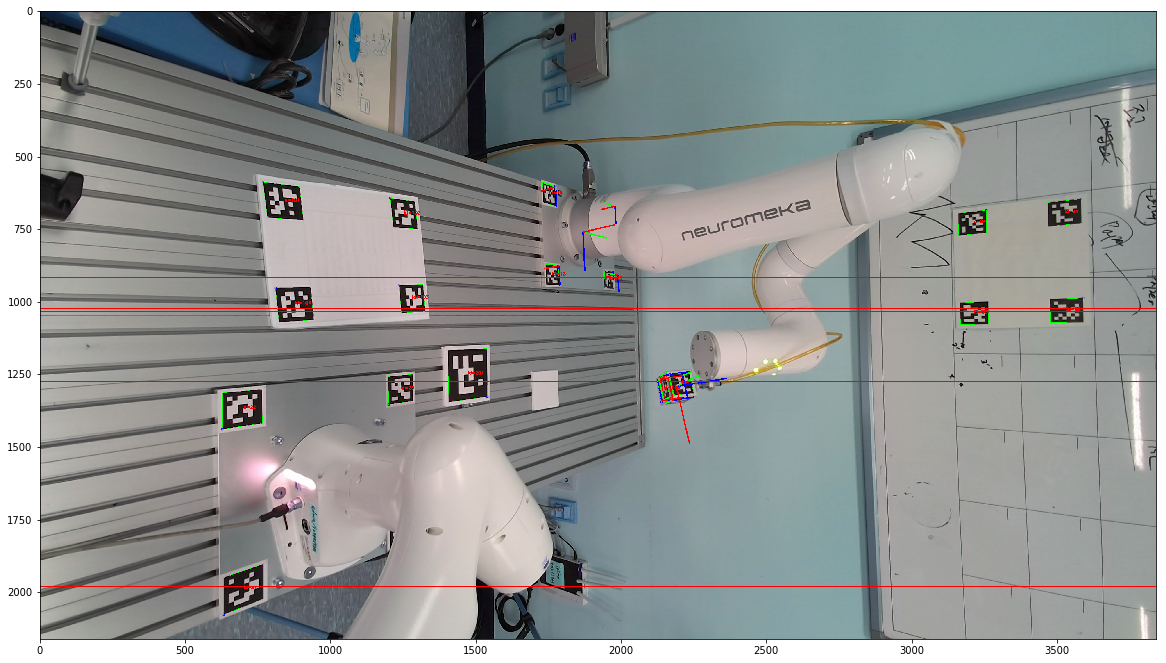

In [16]:
xyz_cam, rvec_cam, xyz_cal, rvec_cal, color_image, objectPose_dict, corner_dict, err_dict = graph.sample_Trel('box1', 'indy0_tcp', 'indy0_link0', 'indy0', Teo=Teo_ref, 
                                                                                                              objectPose_dict_ref={'indy0': objectPose_dict['indy0']})
color_image_out = graph.draw_objects_graph(color_image, objectPose_dict, corner_dict)
plt.figure(figsize=(20,18))
plt.imshow(color_image_out)
print(err_dict)

In [17]:
sample_list.append((xyz_cam, rvec_cam, xyz_cal, rvec_cal, color_image, objectPose_dict))
image_list.append(color_image_out.copy())
len(sample_list)

1

In [18]:
# del sample_list[-1]
# del image_list[-1]

## calibrate

In [19]:
from pkg.calibrator import *

In [20]:
from pkg import calibrator

In [21]:
from pymanopt.solvers import SteepestDescent, NelderMead, ConjugateGradient, TrustRegions

In [22]:
set_RP_calib(sample_list)
T_err((np.identity(3), (0,0,0), np.identity(3), (0,0,0)))

0.059921381309263895

In [85]:
T_bbbr, T_rooo = calibrate_offset(SteepestDescent)
res_sd = T_bbbr, T_rooo
Xopt = (SE3_R(T_bbbr), SE3_P(T_bbbr), SE3_R(T_rooo), SE3_P(T_rooo))
T_err(Xopt)

Compiling cost function...
Computing gradient of cost function...
 iter		   cost val	    grad. norm
    1	+1.7896039851748636e+01	6.59489694e+00
    2	+1.3307979152588628e+01	3.65031263e+00
    3	+1.1389485270692633e+01	5.39865955e+00
    4	+6.9609072838144286e+00	1.87814632e+00
    5	+5.3014344237952056e+00	2.76151728e+00
    6	+3.6603332765113494e+00	1.38459975e+00
    7	+3.0779022273015295e+00	1.43204345e+00
    8	+2.6673398905252443e+00	1.09755845e+00
    9	+2.4816580434827817e+00	1.13179857e+00
   10	+2.3417188049091817e+00	9.74028512e-01
   11	+2.2887901924957910e+00	9.71532293e-01
   12	+2.1581714789864859e+00	2.90404382e-01
   13	+2.1400631927708487e+00	3.40435772e-01
   14	+2.1324843407537135e+00	3.65530494e-01
   15	+2.1132658928728234e+00	1.31119345e-01
   16	+2.1069925202962354e+00	2.25632594e-01
   17	+2.0978715632552527e+00	1.67689098e-01
   18	+2.0912591038598221e+00	2.03730994e-01
   19	+2.0843820741271997e+00	2.60211503e-01
   20	+2.0721852500558033e+00	1.90249499e-01


0.0020201360661242554

In [86]:
T_bbbr, T_rooo = calibrate_offset(TrustRegions)
res_tr = T_bbbr, T_rooo
Xopt = (SE3_R(T_bbbr), SE3_P(T_bbbr), SE3_R(T_rooo), SE3_P(T_rooo))
T_err(Xopt)

Compiling cost function...
Computing gradient of cost function...
Computing Hessian of cost function...
Optimizing...
                                            f: +8.950146e+00   |grad|: 3.844008e+00
acc       k:     1     num_inner:     0     f: +6.417017e+00   |grad|: 2.355423e+00   exceeded trust region
acc       k:     2     num_inner:     0     f: +4.316305e+00   |grad|: 2.069634e+00   negative curvature
acc       k:     3     num_inner:     0     f: +2.921050e+00   |grad|: 1.105035e+00   negative curvature
acc       k:     4     num_inner:     0     f: +2.355533e+00   |grad|: 6.213511e-01   negative curvature
REJ TR-   k:     5     num_inner:     0     f: +2.355533e+00   |grad|: 6.213511e-01   exceeded trust region
acc       k:     6     num_inner:     0     f: +2.242767e+00   |grad|: 4.226648e-01   exceeded trust region
acc TR+   k:     7     num_inner:     0     f: +2.158238e+00   |grad|: 3.477144e-01   negative curvature
acc       k:     8     num_inner:     0     f: +2.0790

0.002068118416132704

In [87]:
T_bbbr, T_rooo = calibrate_offset(ConjugateGradient)
res_cg = T_bbbr, T_rooo
Xopt = (SE3_R(T_bbbr), SE3_P(T_bbbr), SE3_R(T_rooo), SE3_P(T_rooo))
T_err(Xopt)

Compiling cost function...
Computing gradient of cost function...
Optimizing...
 iter		   cost val	    grad. norm
    0	+2.2266728344628724e+01	1.03663216e+01
    1	+1.3747708519802956e+01	6.75789182e+00
    2	+7.9277190494526844e+00	2.72837724e+00
    3	+5.8774221189027003e+00	2.56519536e+00
    4	+3.0942938607087207e+00	2.59455851e+00
    5	+1.7940334095388140e+00	1.53173704e+00
    6	+1.4219034805798942e+00	1.07271309e+00
    7	+1.0858996284952516e+00	7.34903249e-01
    8	+7.5318415462736010e-01	5.91822002e-01
    9	+4.6742278358073425e-01	9.65248374e-01
   10	+1.9804380698759577e-01	5.42049532e-01
   11	+1.2783498910835348e-01	3.57034782e-01
   12	+8.3375401721186113e-02	2.35820941e-01
   13	+4.9368293401222008e-02	1.78294535e-01
   14	+2.4239391450605725e-02	2.34133700e-01
   15	+8.5703122533542734e-03	1.23066771e-01
   16	+5.2744113708745235e-03	4.67550695e-02
   17	+4.5101365305840069e-03	3.96245732e-02
   18	+3.5024652159328469e-03	3.29142228e-02
   19	+2.9548137604843900e-03	3

0.002020136022201011

In [88]:
T_bbbr, T_rooo = calibrate_offset(NelderMead)
res_nm = T_bbbr, T_rooo
Xopt = (SE3_R(T_bbbr), SE3_P(T_bbbr), SE3_R(T_rooo), SE3_P(T_rooo))
T_err(Xopt)

Compiling cost function...
Cost evals:      13	Best cost: +6.58565882e+00
Outside contraction
Cost evals:      15	Best cost: +6.58565882e+00
Reflection
Cost evals:      16	Best cost: +6.58565882e+00
Inside contraction
Cost evals:      18	Best cost: +6.58565882e+00
Shrinkage


TypeError: list indices must be integers, not numpy.float64

In [90]:
# save_offset("indy_sd", res_sd[0], res_sd[1], Teo_ref)
# save_offset("indy_tr", res_tr[0], res_tr[1], Teo_ref)
# save_offset("indy_cg", res_cg[0], res_cg[1], Teo_ref)

In [89]:
save_offset("indy", T_bbbr, T_rooo, Teo_ref)

In [29]:
T_bbbr, T_rooo, Teo_ref = load_offset("indy")

# Calibration - panda

## Sample configurations

In [12]:
graph.set_camera_config(aruco_map, dictionary, cameraMatrix, distCoeffs, corner_dict)

In [13]:
if TEST_CALIB:
    Teo_ref = Teo_ref_load_panda
else:
    Teo_ref = SE3(Rot_zyx(-np.pi/2,np.pi/2,0), [0,0,0.091])

In [14]:
sample_list = []
image_list = []

In [30]:
xyz_cam, rvec_cam, xyz_cal, rvec_cal, color_image, objectPose_dict_err-dict = graph.sample_Trel('box1', 'panda1_hand', 'panda1_link0', 'panda1', Teo=Teo_ref)
color_image_out = graph.draw_objects_graph(color_image, objectPose_dict)
plt.figure(figsize=(20,18))
plt.imshow(color_image_out)

SyntaxError: can't assign to operator (<ipython-input-30-6144a8c94677>, line 1)

In [16]:
sample_list.append((xyz_cam, rvec_cam, xyz_cal, rvec_cal, color_image, objectPose_dict))
image_list.append(color_image_out.copy())

## calibrate

In [46]:
from pkg.calibrator import *
from pkg import calibrator

In [47]:
calibrator.CALIB_TIMEOUT = 30

In [48]:
set_RP_calib(sample_list)
T_err((np.identity(3), (0,0,0), np.identity(3), (0,0,0)))

0.6605868077991914

In [49]:
T_bbbr, T_rooo = calibrate_offset()

Compiling cost function...
Computing gradient of cost function...
 iter		   cost val	    grad. norm
    1	+9.7310039785152966e+00	4.92656279e+00
    2	+6.9380927576378530e+00	2.82403011e+00
    3	+1.1840074993886334e+00	3.19962202e+00
    4	+4.3544547066047007e-01	2.13935455e+00
    5	+9.7241162934490061e-02	3.17058767e-01
    6	+8.8097438748407392e-02	1.35988672e-01
    7	+8.6551666415390457e-02	8.60610752e-02
    8	+8.5917777465651490e-02	4.67478773e-02
    9	+8.5607726834190878e-02	4.55692482e-02
   10	+8.5311880315084493e-02	4.65535448e-02
   11	+8.5015798117641025e-02	4.33926232e-02
   12	+8.4720084603659152e-02	4.65621834e-02
   13	+8.4425463396070793e-02	4.33499263e-02
   14	+8.4131613083715251e-02	4.63921992e-02
   15	+8.3838768565975330e-02	4.32403741e-02
   16	+8.3546682954982368e-02	4.62331155e-02
   17	+8.3255623377935684e-02	4.31326030e-02
   18	+8.2965342161706188e-02	4.60706342e-02
   19	+8.2676098703886841e-02	4.30213662e-02
   20	+8.2387650133274939e-02	4.59058820e-02


  184	+4.9366038440934581e-02	2.65149639e-02
  185	+4.9244205227199751e-02	3.13836719e-02
  186	+4.9122489928780190e-02	2.61985723e-02
  187	+4.9001871562568078e-02	3.13813923e-02
  188	+4.8881344617921554e-02	2.58839503e-02
  189	+4.8761896415779375e-02	3.13838788e-02
  190	+4.8642515470713271e-02	2.55715984e-02
  191	+4.8524194439000481e-02	3.13904680e-02
  192	+4.8405918839334275e-02	2.52619438e-02
  193	+4.8288683969033838e-02	3.14005108e-02
  194	+4.8171474991936344e-02	2.49553366e-02
  195	+4.8055287466222438e-02	3.14133883e-02
  196	+4.7939108478508061e-02	2.46520494e-02
  197	+4.7823931797809804e-02	3.14285226e-02
  198	+4.7708748346465921e-02	2.43522824e-02
  199	+4.7594548381230423e-02	3.14453838e-02
  200	+4.7480328225153107e-02	2.40561707e-02
  201	+4.7367073209273303e-02	3.14634933e-02
  202	+4.7367002399135300e-02	5.69919326e-02
  203	+4.7366719234097694e-02	5.69615404e-02
  204	+4.7365587782664878e-02	5.68399670e-02
  205	+4.7361081347640208e-02	5.63536056e-02
  206	+4.7

  369	+3.4938848112234341e-02	1.87368661e-02
  370	+3.4906881592269928e-02	9.02500713e-03
  371	+3.4861352470646090e-02	3.15341789e-02
  372	+3.4785978184890737e-02	1.15126807e-02
  373	+3.4780658417366925e-02	2.45541176e-02
  374	+3.4761668482850352e-02	1.93640022e-02
  375	+3.4728943854069785e-02	1.07886564e-02
  376	+3.4715428434018314e-02	2.14632131e-02
  377	+3.4679978707695097e-02	9.08148002e-03
  378	+3.4646210348818915e-02	2.04519016e-02
  379	+3.4637246312718570e-02	2.43321445e-02
  380	+3.4608023296179971e-02	1.56601906e-02
  381	+3.4584518539892611e-02	1.18191931e-02
  382	+3.4566124623632281e-02	1.38961665e-02
  383	+3.4556122566676284e-02	2.00148476e-02
  384	+3.4527617969773418e-02	9.90985684e-03
  385	+3.4508635481075370e-02	1.89336557e-02
  386	+3.4478058758216662e-02	1.12391983e-02
  387	+3.4466693401702199e-02	1.99897805e-02
  388	+3.4436178571046944e-02	8.93479222e-03
  389	+3.4407044607402820e-02	1.87152119e-02
  390	+3.4399878310266106e-02	2.32564239e-02
  391	+3.4

RuntimeError: Timeout: Not converged!

In [33]:
# save_offset("panda", T_bbbr, T_rooo, Teo_ref)

In [62]:
T_bbbr, T_rooo, Teo_ref = load_offset("panda")

In [28]:
Xopt = (SE3_R(T_bbbr), SE3_P(T_bbbr), SE3_R(T_rooo), SE3_P(T_rooo))
T_err(Xopt)

0.0008191987154324842

In [62]:
graph.panda.move_finger(True)

True

In [19]:
graph.panda.move_finger(False)

False

# find_proper_offset - indy

In [34]:
val_dict  = {}
for i_x in range(-2,2):
    for i_y in range(-2,2):
        for i_z in range(-2,2):
            sample_list = []
#             image_list = []
            
            xyz_cam, rvec_cam, xyz_cal, rvec_cal, color_image, objectPose_dict, coner_dict, err_dict = graph.sample_Trel('box1', 'indy0_tcp', 'indy0_link0', 'indy0', 
                                                                                             Teo= np.matmul(SE3(Rot_axis(3,np.pi*2/16), [0,0,0]), 
                                                                                                            SE3(Rot_zyx(np.pi/2*i_x,np.pi/2*i_y,np.pi/2*i_z), [-0.055,0,0.071])))
#             color_image_out = draw_objects_graph(self, color_image, objectPose_dict)
#             plt.figure(figsize=(20,18))
#             plt.imshow(color_image_out)

            sample_list.append((xyz_cam, rvec_cam, xyz_cal, rvec_cal, color_image, objectPose_dict))
#             image_list.append(color_image_out.copy())

            set_RP_calib(sample_list)
            print("done: {}".format((i_x, i_y,i_z)))
            val_dict[(i_x, i_y,i_z)] = T_err((np.identity(3), (0,0,0), np.identity(3), (0,0,0)))
print("min error case: {}".format(sorted(val_dict.items(), key=lambda x: x[1])[0]))

done: (-2, -2, -2)
done: (-2, -2, -1)
done: (-2, -2, 0)
done: (-2, -2, 1)
done: (-2, -1, -2)
done: (-2, -1, -1)
done: (-2, -1, 0)
done: (-2, -1, 1)
done: (-2, 0, -2)
done: (-2, 0, -1)
done: (-2, 0, 0)
done: (-2, 0, 1)
done: (-2, 1, -2)
done: (-2, 1, -1)
done: (-2, 1, 0)
done: (-2, 1, 1)
done: (-1, -2, -2)
done: (-1, -2, -1)
done: (-1, -2, 0)
done: (-1, -2, 1)
done: (-1, -1, -2)
done: (-1, -1, -1)
done: (-1, -1, 0)
done: (-1, -1, 1)
done: (-1, 0, -2)
done: (-1, 0, -1)
done: (-1, 0, 0)
done: (-1, 0, 1)
done: (-1, 1, -2)
done: (-1, 1, -1)
done: (-1, 1, 0)
done: (-1, 1, 1)
done: (0, -2, -2)
done: (0, -2, -1)
done: (0, -2, 0)
done: (0, -2, 1)
done: (0, -1, -2)
done: (0, -1, -1)
done: (0, -1, 0)
done: (0, -1, 1)
done: (0, 0, -2)
done: (0, 0, -1)
done: (0, 0, 0)
done: (0, 0, 1)
done: (0, 1, -2)
done: (0, 1, -1)
done: (0, 1, 0)
done: (0, 1, 1)
done: (1, -2, -2)
done: (1, -2, -1)
done: (1, -2, 0)
done: (1, -2, 1)
done: (1, -1, -2)
done: (1, -1, -1)
done: (1, -1, 0)
done: (1, -1, 1)
done: (1, 0,

# find_proper_offset - panda

In [63]:
val_dict  = {}
for i_x in range(-2,2):
    for i_y in range(-2,2):
        for i_z in range(-2,2):
            sample_list = []
#             image_list = []
            
            xyz_cam, rvec_cam, xyz_cal, rvec_cal, color_image, objectPose_dict = graph.sample_Trel('box1', 'panda1_hand', 'panda1_link0', 'panda1', 
                                                                                             Teo=SE3(Rot_zyx(np.pi/2*i_x,np.pi/2*i_y,np.pi/2*i_z), [0,0,0.091]))
#             color_image_out = draw_objects_graph(self, color_image, objectPose_dict)
#             plt.figure(figsize=(20,18))
#             plt.imshow(color_image_out)

            sample_list.append((xyz_cam, rvec_cam, xyz_cal, rvec_cal, color_image, objectPose_dict))
#             image_list.append(color_image_out.copy())

            set_RP_calib(sample_list)
            print("done: {}".format((i_x, i_y,i_z)))
            val_dict[(i_x, i_y,i_z)] = T_err((np.identity(3), (0,0,0), np.identity(3), (0,0,0)))
print("min error case: {}".format(sorted(val_dict.items(), key=lambda x: x[1])[0]))

done: (-2, -2, -2)
done: (-2, -2, -1)
done: (-2, -2, 0)
done: (-2, -2, 1)
done: (-2, -1, -2)
done: (-2, -1, -1)
done: (-2, -1, 0)
done: (-2, -1, 1)
done: (-2, 0, -2)
done: (-2, 0, -1)
done: (-2, 0, 0)
done: (-2, 0, 1)
done: (-2, 1, -2)
done: (-2, 1, -1)
done: (-2, 1, 0)
done: (-2, 1, 1)
done: (-1, -2, -2)
done: (-1, -2, -1)
done: (-1, -2, 0)
done: (-1, -2, 1)
done: (-1, -1, -2)
done: (-1, -1, -1)
done: (-1, -1, 0)
done: (-1, -1, 1)
done: (-1, 0, -2)
done: (-1, 0, -1)
done: (-1, 0, 0)
done: (-1, 0, 1)
done: (-1, 1, -2)
done: (-1, 1, -1)
done: (-1, 1, 0)
done: (-1, 1, 1)
done: (0, -2, -2)
done: (0, -2, -1)
done: (0, -2, 0)
done: (0, -2, 1)
done: (0, -1, -2)
done: (0, -1, -1)
done: (0, -1, 0)
done: (0, -1, 1)
done: (0, 0, -2)
done: (0, 0, -1)
done: (0, 0, 0)
done: (0, 0, 1)
done: (0, 1, -2)
done: (0, 1, -1)
done: (0, 1, 0)
done: (0, 1, 1)
done: (1, -2, -2)
done: (1, -2, -1)
done: (1, -2, 0)
done: (1, -2, 1)
done: (1, -1, -2)
done: (1, -1, -1)
done: (1, -1, 0)
done: (1, -1, 1)
done: (1, 0,